# Première approche : RNN predicting one stock

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html#normalization

In [56]:
!pip install yfinance
!pip install mpld3
!pip install pytorchtools
!pip install torchvision
!pip install chart_studio

In [57]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

## Stock DATASET

In [58]:
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torch.nn import LSTM, Module, Dropout, ModuleList

import yfinance as yf
import pandas as pd
import numpy as np
import os

from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins

In [59]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, nb_steps: int=30, normalize=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.nb_steps = nb_steps
        self.normalize = normalize

    def __len__(self) -> int:
        return len(self.data) - self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = self.data['Close'][index:index+self.nb_samples+2]

        if self.normalize:
            # Drops the first value which was used to normalize other sample values
            sample = self.transform(sample)[1:] 
        else:
            sample = sample[1:]

        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

# def relative_difference(sample: torch.Tensor) -> torch.Tensor:
#     return torch.diff(sample)/sample[:-1]

Test d'une autre manière de gérer le dataset, plus proche de l'implémentation proposé dans l'article :

In [67]:
 class StockPriceDataset_multiple_steps(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, nb_steps: int=30, normalize: bool=True,
                 file_dir: str="data/", csv_file: str=None):
      
        self.nb_samples = nb_samples
        self.nb_steps = nb_steps
        self.normalize = normalize

        if csv_file is not None: # If a local data file must be loaded:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')
        else: # Data must be loaded on an online database:
            data = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
        
        self.data = data
        seq = data['Close'].tolist()

        # split into items of size nb_samples
        seq = [np.array(seq[i*self.nb_samples:(i+1)*self.nb_samples]) for i in range(len(seq)//self.nb_samples)]

        if self.normalize:
            normalization_values = [seq[0][0]] + [seq[i-1][-1] for i in range(len(seq[1:]))]
            seq = [seq[0] / seq[0][0] - 1.0] + [curr / seq[i-1][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        samples = np.array([seq[i: i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])
        labels = np.array([seq[i + self.nb_steps] for i in range(len(seq) - self.nb_steps)])

        self.samples = samples
        self.labels = labels
        self.normalization_values = normalization_values


    def __len__(self) -> int:
        return len(self.samples)-1


    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = torch.tensor(self.samples[index])
        label = torch.tensor(self.labels[index])
        return sample, label
      

    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.normalization_values[index]

In [68]:
VISUALIZE_DATASET = False
if VISUALIZE_DATASET:
  dataset = StockPriceDataset_multiple_steps(start_date='1950-01-03',
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15,
                              normalize=True)
  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print("len dataset =", len(dataset))

## Modèle

In [69]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, dropout, proj_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.proj_size = proj_size
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers, dropout=dropout, batch_first=True, proj_size=self.proj_size)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]
    

## Configuration

In [70]:
class StockAIConfig():
    config = {
        "model":{
            "input_size": 5,
            "lstm_size": 128,
            "num_layers": 1,
            "dropout": 0.2,
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2008-11-16',
            "interval_date": '1d',
            "nb_samples": 5,
            "nb_steps": 30,
            "batch_size": 64,
            "shuffle":False
        },

        "dataset_test":{
            "start_date": '2010-11-17',
            "end_date": '2021-11-16',
            "interval_date": '1d',
            "batch_size": 64,
            "shuffle":False
        },

        "learning":{
            "num_steps": 30,
            "init_lr": 1e-03,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 50
        }   
    }

## Initialisation des datasets et du modèle

In [83]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the dataset
dataset_train = StockPriceDataset_multiple_steps(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            config["dataset_train"]["nb_steps"],
                            normalize=True)

# Init dataloader of the dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

# Init of the dataset_test
dataset_test = StockPriceDataset_multiple_steps(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            config["dataset_train"]["nb_steps"],
                            normalize=True)

# Init dataloader of dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], config["dataset_test"]["shuffle"], drop_last=True)

# Init of the model
model = StockAI(config["model"]["input_size"],
                config["model"]["lstm_size"],
                config["model"]["num_layers"],
                config["model"]["dropout"],
                config["dataset_train"]["nb_samples"])

model.to(device)

# Learning rate to use along the epochs
learning_rates = [config["learning"]["init_lr"]*(config["learning"]["lr_decay"]**max(float(i+1 - config["learning"]["init_epoch"]), 0.0)) for i in range(config["learning"]["max_epoch"])]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rates[0], eps=1e-08)

# to track the training loss as the model trains
train_losses = []

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



In [84]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
      
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Training loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [85]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=3, delta=0, verbose=False)

In [86]:
x, y = dataset_train.__getitem__(0)
print(x.shape)
print(y.shape)

torch.Size([30, 5])
torch.Size([5])


## Apprentissage

In [87]:
# Learning
STOCK_PRICE_DATASET_MULTIPLE_STEPS = True
# to track the average training loss per epoch as the model trains
avg_train_losses = []

for epoch in range(config["learning"]["max_epoch"]):
    lr = learning_rates[epoch]
    print(f"Running for epoch {epoch}...")
    running_loss = 0.0

    ######################
    #  train the model   #
    ######################
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
          x = torch.unsqueeze(x, -1).float()
        else:
          x = x.float()
        y = y.float()
        x, y = x.to(device), y.to(device)

        y_pred = torch.squeeze(model.forward(x))
        loss = loss_fn(y_pred, y)
        train_losses.append(loss.item())

        if i_batch%10==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print training/validation statistics --> calculate average loss over an epoch
    train_loss = np.average(train_losses)
    avg_train_losses.append(train_loss)

    # clear lists to track next epoch
    train_losses = []
    
    # early_stopping needs the validation loss to check if it has decreased, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(train_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Running for epoch 0...
step: 0, loss = 0.0013078402262181044
step: 10, loss = 0.0001459838094888255
step: 20, loss = 0.00037629081634804606
step: 30, loss = 0.0004190177714917809
step: 40, loss = 0.001362148323096335
Running for epoch 1...
step: 0, loss = 0.00046579554327763617
step: 10, loss = 0.00012894425890408456
step: 20, loss = 0.0003260792000219226
step: 30, loss = 0.0003839701821561903
step: 40, loss = 0.0012119829189032316
Running for epoch 2...
step: 0, loss = 0.0004231802304275334
step: 10, loss = 0.00011268430534983054
step: 20, loss = 0.00028836936689913273
step: 30, loss = 0.0003236045886296779
step: 40, loss = 0.0009652191656641662
Running for epoch 3...
step: 0, loss = 0.00033531655208207667
step: 10, loss = 8.698983583599329e-05
step: 20, loss = 0.0002134731039404869
step: 30, loss = 0.00023188619525171816
step: 40, loss = 0.0007570094894617796
Running for epoch 4...
step: 0, loss = 0.00025273027131333947
step: 10, loss = 7.152301259338856e-05
step: 20, loss = 0.000194

In [88]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.4.2.min.js?noext',
            },
          });
        </script>
        '''))

In [89]:
print(len(np.arange(epoch)))
print(len(np.array(avg_train_losses)))
df = pd.DataFrame({
    "epochs": np.arange(epoch),
    "training_loss": np.array(avg_train_losses)[1:] # Remove the first value because outlier
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='epochs', y=['training_loss'], color=['white'], 
         theme='solar', mode='lines', title='Training_loss across epochs')
plt.show()

49
50


In [90]:
#test
runnning_mape = 0
for i_batch, batch in enumerate(dataloader_test):
        x, y = batch
        if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
          x = torch.unsqueeze(x, -1).float()
        else:
          x = x.float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y = torch.squeeze(y)
        y_pred = torch.squeeze(model.forward(x))
        error = torch.mean(torch.abs((y - y_pred) / y))
        runnning_mape += error

mape = runnning_mape / len(dataloader_test)
print("mean absolute error percentage = ", mape.item()*100, "%")

mean absolute error percentage =  200.4359006881714 %


In [91]:
from sklearn.metrics import mean_squared_error

## Prédiction 

### A partir des 15 dernières valeurs réelles

In [92]:
# Predict one following sample, taking the nb_samples last real values of S&P500
nb_test = len(dataset_test) - config["dataset_train"]["nb_steps"]
print("longueur du dataset test = ", nb_test)
y_truth_norm, y_truth, y_hat_norm, y_hat = [], [], [], []

for i in range(nb_test):
  x, y = dataset_test.__getitem__(i)
  norm_value = dataset_test.get_normalization_value(i)
  print("norm_value = ", norm_value)
  if not STOCK_PRICE_DATASET_MULTIPLE_STEPS:
    x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  else:
    x = torch.unsqueeze(x, 0).float()
  x = x.to(device)

  y_pred = torch.squeeze(model.forward(x))

  y_truth_norm.append(float(torch.Tensor.cpu(y).detach()[-1].numpy()))
  y_truth.append(float(torch.Tensor.cpu(y).detach()[-1].numpy()*norm_value))
  y_hat_norm.append(float(torch.Tensor.cpu(y_pred).detach()[-1].numpy()))
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach()[-1].numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)-config["dataset_train"]["nb_steps"]),
    "real_value_norm": y_truth_norm, 
    "real_value": y_truth,
    "predicted_value_norm":y_hat_norm,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
# Plot with normalized values
df.iplot(kind='line', x='sample_id', y=['real_value_norm','predicted_value_norm'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (normalized values)', size=10)

# Plot with denormalized ("real") values
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (real values)', size=10)

plt.show()

metrics1 = {
    "MSE_between_normalized": mean_squared_error(y_truth_norm, y_hat_norm),
    "MSE_between_real": mean_squared_error(y_truth, y_hat)
}

print("\n Metrics for learning with real values of S&P500 : \n ", metrics1)

longueur du dataset test =  492



 Metrics for learning with real values of S&P500 : 
  {'MSE_between_normalized': 0.00051278554883603, 'MSE_between_real': 3004.5020279256896}


### A partir des valeurs déjà prédites

In [ ]:
# Predict one following sample, taking the nb_samples lastly predicted values of S&P500
nb_test = len(dataset_test)
nb_samples = config["dataset_test"]["nb_samples"]
print("longueur du dataset test = ", nb_test)
y_truth, y_hat, y_truth_norm, y_hat_norm = [], [], [], []
x, y = dataset_test.__getitem__(0)
x, y = x.to(device), y.to(device)

for i in range(nb_test):

  _, y = dataset_test.__getitem__(i)

  # Normalization value for the current batch, needed to reproduce real value
  norm_value = dataset_test.get_normalization_value(i)
  x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  x = x.to(device)

  # model computations + prediction
  y_pred = model.forward(x)

  # Ajout du y_pred à la fin du tenseur x et retrait de sa première valeur pour incrémenter d'une période temporelle
  x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))
  # print("y_pred = {}".format(y_pred))
  # print("x = {}".format(x))

  y_truth_norm.append(torch.Tensor.cpu(y).detach().numpy())
  y_truth.append(torch.Tensor.cpu(y).detach().numpy()*norm_value)
  y_hat_norm.append(float(torch.Tensor.cpu(y_pred).detach().numpy()))
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach().numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)),
    "real_value_norm": y_truth_norm, 
    "real_value": y_truth,
    "predicted_value_norm":y_hat_norm,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
# Plot with normalized values
df.iplot(kind='line', x='sample_id', y=['real_value_norm','predicted_value_norm'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (normalized values)', size=10)

# Plot with real values
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data')
plt.show()

metrics2 = {
    "MSE_between_normalized": mean_squared_error(y_truth_norm, y_hat_norm),
    "MSE_between_real": mean_squared_error(y_truth, y_hat)
}

print("\n Metrics for learning with lastly predicted values of S&P500 : \n ", metrics2)

longueur du dataset test =  3257



 Metrics for learning with lastly predicted values of S&P500 : 
  {'MSE_between_normalized': 0.02279621969898304, 'MSE_between_real': 119458.47602525371}


In [ ]:
# Test pour prédire la valeur de demain du S&P500
nb_samples = 15
x = dataset_train.data['Close'][-16:-1]
mean_value = np.mean(x)
last_value = x[-1]
norm_value = x[0]
print("last 15 values of S&P500 : ", x)
x = x/norm_value
x = torch.unsqueeze(torch.unsqueeze(torch.Tensor(x), 0), -1)

# 31/12/21
y_pred = model.forward(x)
x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))
x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()

print("predicted value : y_pred = ", y_pred.item())
print("predicted value = ", y_pred.item()*mean_value)


# Ajout d'une deuxième méthode de prédiction : pluralité des stocks prédits #

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/22/predict-stock-prices-using-RNN-part-2.html

Tests à faire :
- mélanger valeurs prédites et valeurs réelles (sorte de batch hybride)
- hyper-parameter tuning
- test sur les fenêtres de temps
- calculer erreur ou différence par rapport à la moyenne glissante sur les 15 valeurs
- Trouver potentiel problème sur prédiction avec valeurs réelles (car trop beau pour être vrai + incohérence quand plus de valeurs réelles)
- tester de prédire plusieurs valeurs en même temps

In [ ]:
import urllib
from bs4 import BeautifulSoup
from urllib.parse import quote 
from datetime import datetime

Schéma du réseau mis en place :

## 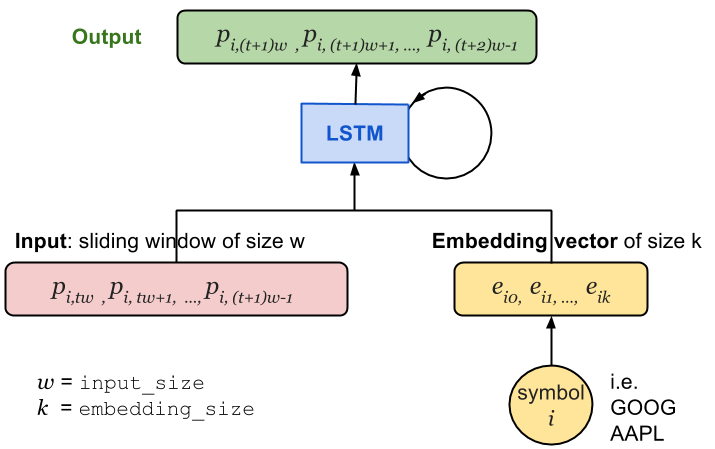

In [ ]:
class StockAI_with_embedding(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True,  proj_size=1)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]

In [ ]:
from typing import List
class StockPriceDataset2(Dataset):
    def __init__(self, list_of_stocks: List=["GOOG"], start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None):
      
        dataset = []
        for stock_name in list_of_stocks:
            dataset.append(yf.download(stock_name, start=start_date, end=end_date, interval=interval))

        start_date, end_date = data_intersection(dataset)
        print("\n Date intersection for all specified stocks is : {} -> {} \n".format(start_date, end_date))

        stock = dataset[0]

        self.data = np.array([stock.iloc[stock.index.isin(np.where(stock.index >= start_date)[0]) and
                                         stock.index.isin(np.where(stock.index <= end_date)[0])] for stock in dataset], dtype='object')

        print("data = \n", data)
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data[0]) - self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = self.data[:][index:index+self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]

def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price


def data_intersection(dataset):
    date_amplitudes = [len(stock.index) for stock in dataset]
    date_start_to_end = np.array([ (stock.index[0], stock.index[-1]) for stock in dataset ])
    ind = np.argmin(date_amplitudes)
    return date_start_to_end[ind]

In [ ]:
# Model config
config = StockAIConfig().config

# Ajout de la configuration pour l'embedding
config["embedding"] = {
    "list_of_stocks":["GOOG", '^GSPC', 'AAPL'], # A modifier si besoin de plus de/d'autres stocks
    "stock_count": 3
}
config["embedding"]["embed_size"] = len(config["embedding"]["list_of_stocks"])

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset2(
    config["embedding"]["list_of_stocks"],
    config["dataset_train"]["start_date"], 
    config["dataset_train"]["end_date"],
    config["dataset_train"]["interval_date"], 
    config["dataset_train"]["nb_samples"],
    transform=normalize_by_last_unknown_price
    )

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

print("dataset_train =", dataset_train.data)

In [ ]:
embedding_matrix = torch.Tensor()
stacked_stock_labels = torch.tile(stock_labels, dims=(1, config["learning"]["num_steps"]))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(list_of_symbols)